In [5]:
import os
import pandas as pd
import numpy as np
import csv

import torch
import torch.nn as nn
import torch.optim as optim

from modelClass import Net

import pickle

In [6]:
filePath =  "../../project_course_data/"

### READ DATA

In [7]:
dataPath = "pilot3.txt"

with open(filePath + dataPath, "r") as f:
    content = f.read().replace("->", " ").replace(" K ", "K ").replace(" M ", "M ").replace(" G ", "G ")

In [8]:
import io

In [9]:
csvStringIO = io.StringIO(content)
columnNames = ["Datetime", "Time", "Duration",  "Proto", "Src IP Addr:Port", "Dst IP Addr:Port", "Packets", "Bytes", "Flows"]

# dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')

data = pd.read_csv(csvStringIO, sep = '\s+', names = columnNames, header = None, usecols=range(len(columnNames)), parse_dates=True, engine = "python")
data = data.iloc[1:-4] #Removes the summary lines and col names

data["Datetime"] += " " + data["Time"]
data = data.drop(columns = ["Time"])

data["Id"] = data.reset_index(drop = True).index



#### Debug func

In [10]:
def printRow(df, id):
    try:
        row = df[df["Id"] == id]
        for col, val in row.iloc[0].items():
            print(f"{col}: {val}")
    except KeyError:
        print(f"Row with id {id} not found in DataFrame.")

In [11]:
id = 332
printRow(data, id)

Datetime: 2023-10-18 18:20:45.577
Duration: 0.000
Proto: TCP
Src IP Addr:Port: 208.67.220.220:443
Dst IP Addr:Port: 192.168.8.177:53934
Packets: 100
Bytes: 5200
Flows: 1
Id: 332


### Data fixing procecssing etc

In [12]:
 # Convert the datetime column to pandas datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Sort the DataFrame by the datetime column
data = data.sort_values(by='Datetime')

# Split IP address and port to two columns, and drops the old column
data[['Src IP Addr', 'Src Port']] = data['Src IP Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst IP Addr', 'Dst Port']] = data['Dst IP Addr:Port'].str.split(':', n=1, expand=True)
data = data.drop(columns=["Src IP Addr:Port", "Dst IP Addr:Port"])


# Changes Duration column to float
data['Duration'] = data['Duration'].astype(float)
# Drop outliers
data = data.drop(data[data.Duration > 10000].index)

# Find clients IP address
client = data['Src IP Addr'].value_counts().idxmax().split('.')
client = '.'.join(client[:3])

# Initialize 'Host IP'-column from 'Src Ip Addr'
data['Host IP'] = data['Src IP Addr']
data['Client IP'] = data['Dst IP Addr']

# Removes all internal flows
# If the destination IP is not equal to the clients IP, adds it to 'Host IP'-column
for index, row in data.iterrows():
    if client in row['Dst IP Addr'] and client in row['Src IP Addr']:
        data.drop(index, inplace=True)
    elif client not in row['Dst IP Addr']:
        data.at[index, 'Host IP'] = row['Dst IP Addr']
        data.at[index, 'Client IP'] = row['Src IP Addr']

#### Fix bytes

In [13]:
def convert_bytes(value):
    value = str(value).upper()
    multipliers = {'K': 1000, 'M': 1000**2, 'G': 1000**3}

    if value[-1] in multipliers:
        return int(float(value[0:-1]) * multipliers[value[-1]])
    else:
        return int(value)

# Apply the conversion function to the 'Bytes' column
data['Bytes'] = data['Bytes'].apply(convert_bytes)
data['Packets'] = data['Packets'].apply(convert_bytes)

In [14]:
id = 332
printRow(data, id)

Datetime: 2023-10-18 18:20:45.577000
Duration: 0.0
Proto: TCP
Packets: 100
Bytes: 5200
Flows: 1
Id: 332
Src IP Addr: 208.67.220.220
Src Port: 443
Dst IP Addr: 192.168.8.177
Dst Port: 53934
Host IP: 208.67.220.220
Client IP: 192.168.8.177


### READ PREDICTIONS

In [15]:
##### REPLACE WITH READING PRED FILE
import random
# REMOVE --------------------------------------
# creating fake preds 
posPreds = list(range(21))
fakePreds = []
# for i in range(len(data)):
#     # fakePreds.append(random.choice(posPreds))
#     fakePreds.append(1)
with open("servocePredsNum.csv", 'r', newline='') as file:
    # Specify the delimiter as a space
    csv_reader = csv.reader(file, delimiter=' ')
    
    # Iterate through each row and append it to the data list
    for row in csv_reader:
        fakePreds.extend(row)

for i in range(len(fakePreds)):
    fakePreds[i] = int(fakePreds[i])

print(len(fakePreds))
print(fakePreds)
# ^^^^^^ --------------------------------------



99995
[6, 6, 5, 6, 3, 3, 5, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 3, 2, 6, 0, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6, 5, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 2, 6, 6, 6, 0, 6, 6, 5, 6, 2, 6, 6, 6, 6, 5, 5, 5, 5, 0, 6, 5, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 5, 6, 3, 5, 6, 5, 6, 5, 5, 6, 6, 6, 6, 6, 3, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 6, 6, 6, 5, 6, 5, 6, 6, 6, 6, 5, 6, 0, 5, 3, 5, 6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 5, 3, 10, 5, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6,

#### calc size of preds

In [16]:
data["Prediction"] = fakePreds

selectedData = data[["Id", "Bytes", "Prediction"]]

id = 332
printRow(selectedData, id)

Id: 332
Bytes: 5200
Prediction: 6


In [17]:
## list of lists of bytes

bytesLOL = [[] for i in range(21)]
print(bytesLOL)

for idx, row in selectedData.iterrows():
    bytesLOL[row["Prediction"]].append(row["Bytes"])

# list of summarized bytes for each class
bytesSumList = []

for lst in bytesLOL:
    bytesSumList.append(sum(lst))
print(bytesSumList)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


[136827300, 0, 1493527497, 5487972897, 0, 11975776996, 5535786796, 122800, 6648898000, 0, 1891900, 0, 0, 0, 17600, 0, 1018348300, 0, 0, 0, 0]


### Print summaries

In [18]:
# Load labels dictionary

labelsDictPath = "labelsDictionary.pkl"

with open(filePath + labelsDictPath, "rb") as pkl_f:
    LABELS_DICT = pickle.load(pkl_f)

print("LABELS AND CORRESPONDING NUMBER:")
for key,val in LABELS_DICT.items():
    print(f"{val}\t{key}")

LABELS AND CORRESPONDING NUMBER:
0	Youtube
1	Netflix
2	Browsing/Shopping
3	Twitch TV
4	Prime Video
5	SVT Play
6	Spotify
7	Facebook
8	Playstation
9	Soundcloud
10	Discord
11	Reddit
12	Amazon SHOP
13	Google Drive
14	Skype
15	Disney+
16	Steam Gaming
17	Gmail
18	Instagram
19	Outlook Mail
20	X


In [19]:
def label2num(label):
    return(LABELS_DICT[label])
def num2label(num):
    return next((key for key, val in LABELS_DICT.items() if val == num), None)

In [20]:
# Service to activity translation

ACTIVITY_DICT = {
    "Youtube":           "Video streaming",
    "Netflix":           "Video streaming",
    "Browsing/Shopping": "Browsing/Shopping",
    "Twitch TV":         "Video streaming",
    "Prime Video":       "Video streaming",
    "SVT Play":          "Video streaming",
    "Spotify":           "Sound streaming",
    "Facebook":          "Social media",
    "Playstation":       "Gaming",
    "Soundcloud":        "Sound streaming",
    "Discord":           "Voice chat",
    "Reddit":            "Social media",
    "Amazon SHOP":       "Browsing/Shopping",
    "Google Drive":      "Browsing/Shopping",
    "Skype":             "Voice chat",
    "Disney+":           "Video streaming",
    "Steam Gaming":      "Gaming",
    "Gmail":             "Browsing/Shopping",
    "Instagram":         "Social media",
    "Outlook Mail":      "Browsing/Shopping",
    "X":                 "Social media",
}

def service2activity(service):
    return(ACTIVITY_DICT[service])

In [58]:
serviceRatio = {}
activityRatio = {}

for idx in range(21):

    service = num2label(idx)
    activity = service2activity(service)

    sz = bytesSumList[idx]
    ratio = sz / sum(bytesSumList) * 100

    serviceRatio[service] = ratio

    activityRatio[activity] = activityRatio[activity] + ratio if activity in activityRatio else ratio
  
for service, ratio in sorted(serviceRatio.items(), key = lambda x: x[1], reverse=True):
    print(f"{service} accounted for {round(ratio,3)}% of total bytes")

print("\n\n")

for activity, ratio in sorted(activityRatio.items(), key = lambda x: x[1], reverse=True):
    print(f"{activity} accounted for {round(ratio,3)}% of total bytes")

SVT Play accounted for 37.078% of total bytes
Playstation accounted for 20.585% of total bytes
Spotify accounted for 17.139% of total bytes
Twitch TV accounted for 16.991% of total bytes
Browsing/Shopping accounted for 4.624% of total bytes
Steam Gaming accounted for 3.153% of total bytes
Youtube accounted for 0.424% of total bytes
Discord accounted for 0.006% of total bytes
Facebook accounted for 0.0% of total bytes
Skype accounted for 0.0% of total bytes
Netflix accounted for 0.0% of total bytes
Prime Video accounted for 0.0% of total bytes
Soundcloud accounted for 0.0% of total bytes
Reddit accounted for 0.0% of total bytes
Amazon SHOP accounted for 0.0% of total bytes
Google Drive accounted for 0.0% of total bytes
Disney+ accounted for 0.0% of total bytes
Gmail accounted for 0.0% of total bytes
Instagram accounted for 0.0% of total bytes
Outlook Mail accounted for 0.0% of total bytes
X accounted for 0.0% of total bytes



Video streaming accounted for 54.492% of total bytes
Gaming 

In [22]:

import squarify 
import matplotlib.pyplot as plt 

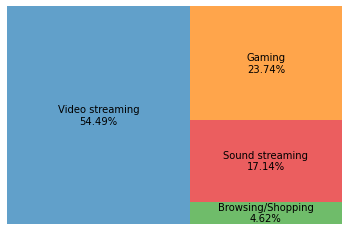

In [59]:
# Example data (replace this with your own data)
activityRatio = {key + "\n" + str(round(value, 2)) + "%": value for key, value in activityRatio.items() if value > 1}
data = activityRatio

# Colors for each group (adjust as needed)
colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a']

# Plotting the squarify treemap
squarify.plot(sizes=data.values(), label=data.keys(), color=colors, alpha=0.7, pad=0)

# Add a legend
#plt.legend(labels=data.keys(), loc='upper left', bbox_to_anchor=(1, 1))

# Remove axis labels and ticks
plt.axis('off')

# Show the plot
plt.show()

In [60]:
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'treemap.svg'

plt.savefig(image_name, format=image_format, dpi=1200)

<Figure size 432x288 with 0 Axes>